# Hierarchical Clustering

Initial hierarchical clustering code.

In [1]:
import snowflake.connector
import os
import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [2]:
liven_merch_df = pd.read_csv("./Match-And-Snap/merchant.csv", names=["Name", "Branch", "Lattitude", "Longitude", "City"])
liven_merch_df = liven_merch_df.drop(liven_merch_df.index[0])
liven_merch_df.head()

,Name,Branch,Lattitude,Longitude,City
1,12 Chairs,Caulfield North,-37.8746549910984,145.02443970154678,Melbourne
2,2042 Cafe,Newtown,-33.8999023490079,151.17794411377133,Sydney
3,4 Ounces Burger,Leichhardt,-33.881667,151.156784,Sydney
4,4 Ounces Burger,Alexandria,-33.899424,151.194507,Sydney
5,4 Ounces Burger,Rushcutters Bay,-33.87608824312447,151.22825162605056,Sydney


In [3]:
# Clean up nan
liven_merch_df = liven_merch_df[~liven_merch_df.Lattitude.isnull()]
liven_merch_df = liven_merch_df[~liven_merch_df.Longitude.isnull()]

In [4]:
syd_merch = liven_merch_df[liven_merch_df["City"] == "Sydney"]
melb_merch = liven_merch_df[liven_merch_df["City"] == "Melbourne"]

#### There are some funky outliers in the data so just deleting them manually.

In [5]:
# Notable things to drop for Syd data
# -210
# -417


# Melb
# 462
# 820
# 582

syd_merch = syd_merch.drop(syd_merch.index[210])
syd_merch = syd_merch.drop(syd_merch.index[417])

melb_merch = melb_merch.drop(melb_merch.index[462])
melb_merch = melb_merch.drop(melb_merch.index[820])
melb_merch = melb_merch.drop(melb_merch.index[582])

In [6]:
syd_locations = syd_merch[["Lattitude", "Longitude"]]
melb_locations = melb_merch[["Lattitude", "Longitude"]]

#### Note: We have n observations so hierarchical clustering will do n-1 merges until we get to 1 giant cluster. Following cell does the actual clustering.

In [7]:
# Performs hierarchical/agglomerative clustering on the condensed distance matrix y.
syd_clustering = linkage(syd_locations, 'ward')
melb_clustering = linkage(melb_locations, 'ward')

Using the Ward variance minimization objective function for clustering [link](https://en.wikipedia.org/wiki/Ward%27s_method).

We should check [Cophenetic correlation](https://en.wikipedia.org/wiki/Cophenetic_correlation) which tells us how well does the dendogram clustering preserve pairwise distances between data points. The closer to 1, the better it does its job.

In [8]:
c, coph_dists = cophenet(syd_clustering, pdist(syd_locations))
print("Value for Syd", c)
c, coph_dists = cophenet(melb_clustering, pdist(melb_locations))
print("Value for Melb", c)

Value for Syd 0.8925036635720203
Value for Melb 0.5154203923872822


Very close to 1 so it's doing a good job!

First row of clustering will tell us
- Which 2 points were merged (informed by index)
- What the distance between the 2 points were
- What is sample size of new cluster

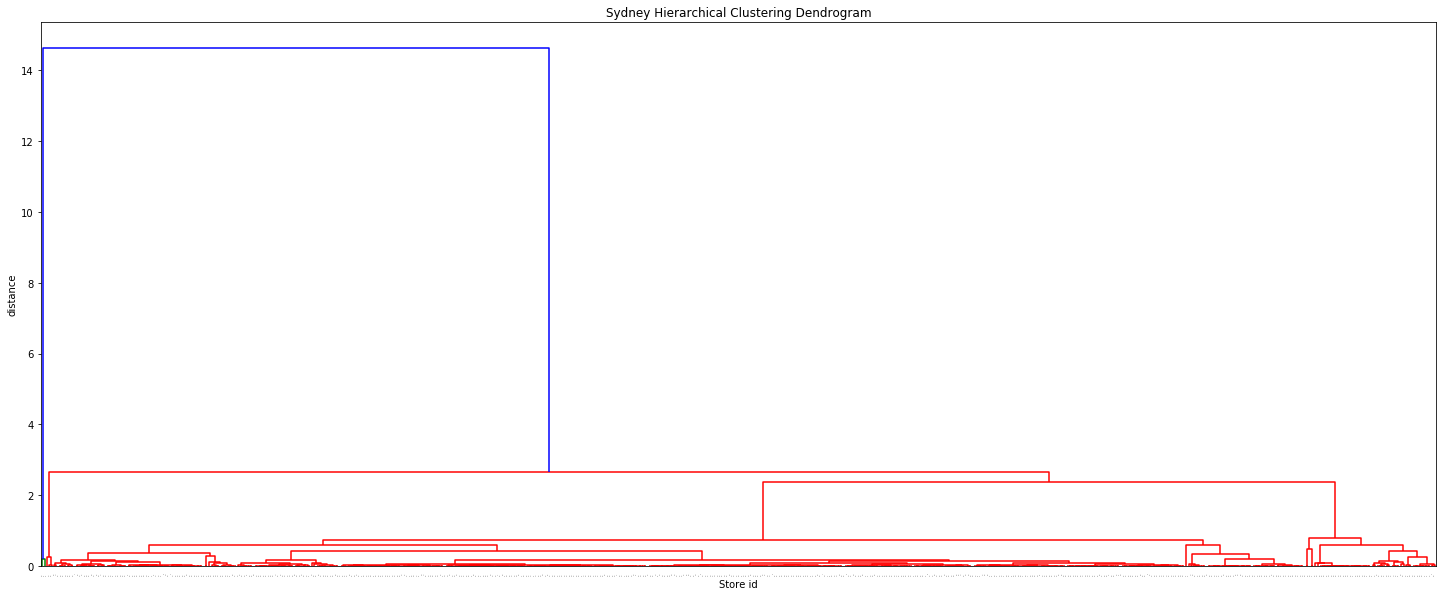

In [9]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Sydney Hierarchical Clustering Dendrogram')
plt.xlabel('Store id')
plt.ylabel('distance')
dendrogram(
    syd_clustering,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=1.,  # font size for the x axis labels
)
plt.show()

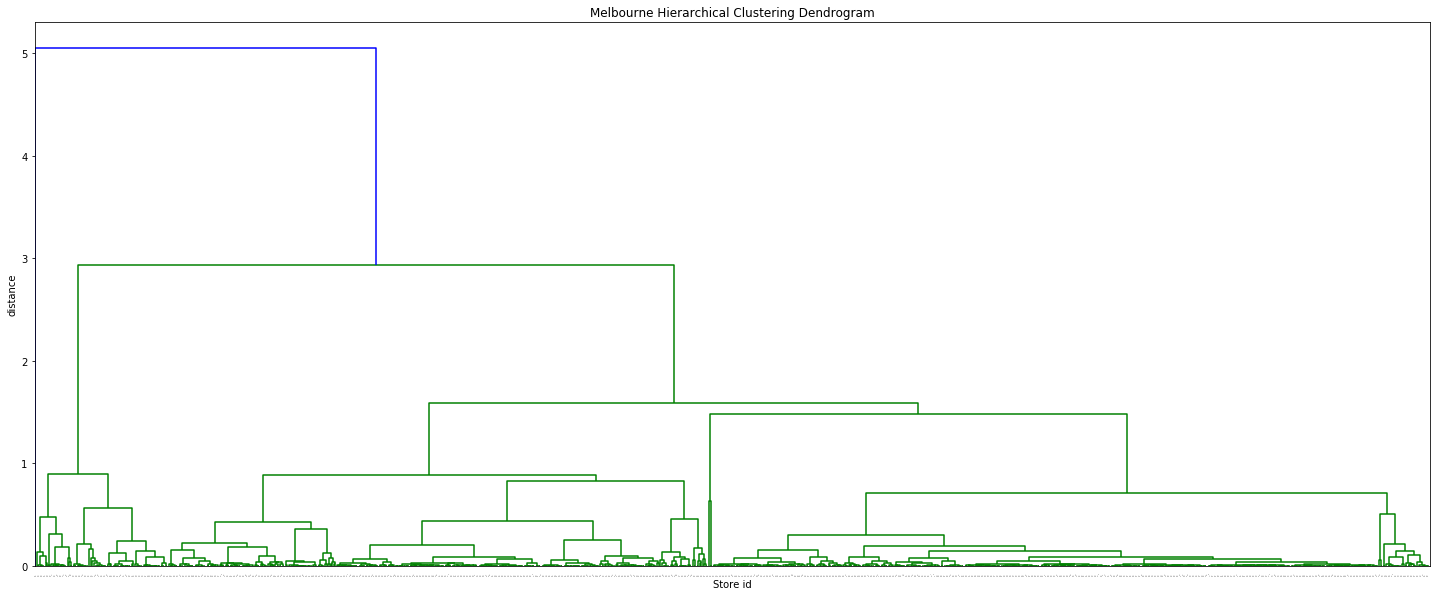

In [10]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Melbourne Hierarchical Clustering Dendrogram')
plt.xlabel('Store id')
plt.ylabel('distance')
dendrogram(
    melb_clustering,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=1.,  # font size for the x axis labels
)
plt.show()

#### Pretty messy so we look at last `p` merges.

In [11]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    city = kwargs["city"]
    del kwargs["city"]
    
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram for {}'.format(city))
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

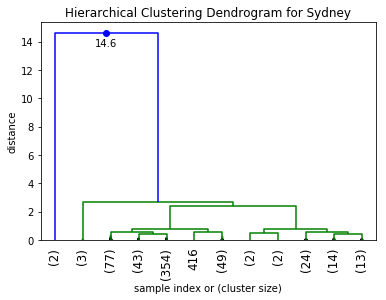

In [12]:
fancy_dendrogram(
    syd_clustering,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    city="Sydney"
)
plt.show()

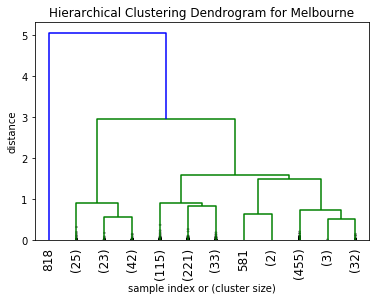

In [13]:
fancy_dendrogram(
    melb_clustering,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    city="Melbourne"
)
plt.show()

In [14]:
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import inconsistent

The t argument tells us what is the criteria for clustering.

# This section gets us the actual labels based on the inconsistent metric.

In [52]:
syd_labels = fcluster(syd_clustering, t=0.3, criterion='distance')
np.unique(syd_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int32)

5 diff clusters.

In [56]:
melb_labels = fcluster(melb_clustering, t=0.4, criterion='distance')
np.unique(melb_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32)

6 diff clusters.

In [53]:
syd_merch["Cluster"] = syd_labels
melb_merch["Cluster"] = melb_labels

In [59]:
syd_merch.to_csv("SYD_Merchants.csv", index=False)
melb_merch.to_csv("MEL_Merchants.csv", index=False)